In [36]:
import geopandas as gpd
import os
import xarray as xr
import numpy as np
import pandas as pd
import pickle
import gc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#import leafmap
import leafmap.foliumap as leafmap
from shapely.geometry import mapping
import pyproj
import folium
from glob import glob


In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tsai.all import *

In [8]:
data_dir = '/mnt/CEPH_PROJECTS/sao/openEO_Platform'

In [9]:
big_pv_geoms = gpd.read_file(f"{data_dir}/germany_photovoltaic.shp")

In [10]:
# Filter the data to have farms bigger then 5 km2
big_pv_geoms_32632 = big_pv_geoms.to_crs(32632)
big_pv_geoms_32632_buffer_20 = big_pv_geoms_32632.copy()
big_pv_geoms_32632_buffer_20["geometry"] = [i.buffer(20) for i in big_pv_geoms_32632_buffer_20.geometry]
big_pv_geoms_buffer = big_pv_geoms_32632_buffer_20.to_crs(4326)

print(f"Number of selected PV Farms: {len(big_pv_geoms_buffer)}")

Number of selected PV Farms: 4458


In [11]:
bands = ['B01','B02','B03','B04',
         'B05','B06','B07','B08',
         'B8A', 'B11', 'B12']

### Extract the data and save them as numpy arrays 
Run this section just for the first time

In [13]:
# Plot random PV farm
farm_id = 2

data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
geom = big_pv_geoms_32632.iloc[farm_id]  

# This step to fill the gaps (nan values) spatially
data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
data.rio.write_crs("epsg:32633", inplace=True) #32633

# Filter clouds pixels
cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
data = data.where(~cloud_mask)

# Clip the farm polygon
clipped = data.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=False)

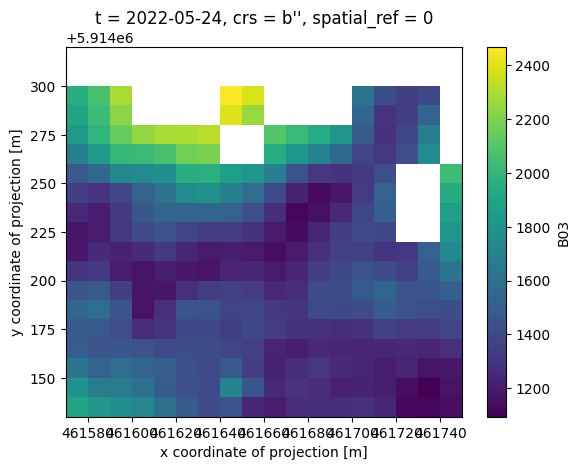

In [14]:
data['B03'][55].plot()

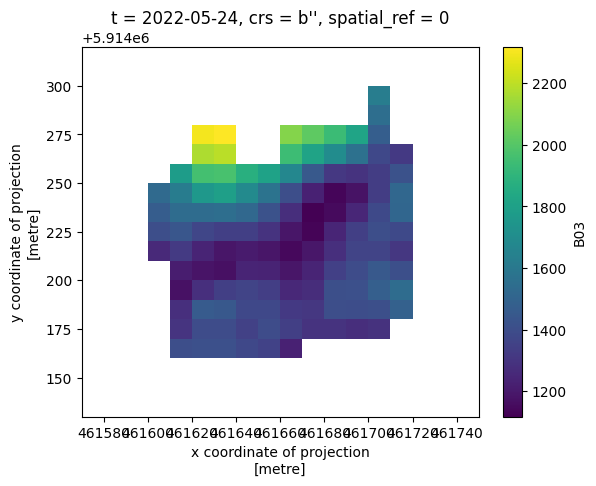

In [15]:
clipped['B03'][55].plot()

In [40]:
def s2_data(pv_farms, start_date='2022-01-01', end_date='2022-12-31',train=True, invert=False):
    
    all_pixels_ts = []
    for pv_farm in pv_farms:
        farm_id = int(pv_farm.split('/')[-1].split('_')[-1].split('.')[0])
        data = xr.open_dataset(f"{data_dir}/s2/germany/s2_2022_{farm_id}.nc",decode_coords="all")
        geom = big_pv_geoms_32632.iloc[farm_id]


         ## Filter clouds pixels
        cloud_mask = np.bitwise_or((data.SCL == 8),(data.SCL == 9))
        geodf = gpd.GeoDataFrame(geometry=[geom["geometry"]],crs="EPSG:32633")
        data = data.where(~cloud_mask)  

        ## This step to fill the gaps (nan values) spatially
        data = data.groupby('t').apply(lambda x: x.fillna(x.mean(dim=('x','y'))))
        data.rio.write_crs("epsg:32633", inplace=True) #32633   

        ## Linear interpolation to have full time-series
        daily_date_range = pd.date_range(start=pd.to_datetime(start_date), 
                                         end=pd.to_datetime(end_date),
                                         freq='D')    

        ds_daily = data.reindex(t=daily_date_range)
        ds_daily_interp = ds_daily.interpolate_na(dim='t', method='linear')   


        ## Clip the farm polygon
        clipped = ds_daily_interp.rio.clip(geodf.geometry.values, geodf.crs, drop=False, invert=invert)


        if train:
            df = clipped.to_dataframe().unstack(level='t')
        else:
            df = ds_daily_interp.to_dataframe().unstack(level='t')
        
        arr_ts= []
        for b in bands:
            df_b = df[b]
            if train:
                df_b = df_b.dropna(how = 'all')
            if invert:
                # Randomly select 25% of the pixels 
                rows_to_filter = int(0.25 * len(df_b))
                df_b = df_b.sample(n=rows_to_filter, random_state=42)
                
            arr_ts.append(np.array(df_b))

        all_pixels_ts.append(np.stack(arr_ts, axis=1))
        
    
    samples = np.vstack(all_pixels_ts)

    
    return samples

In [ ]:
# Extract S2 data for the photvoltaic farms - pixels inside the polygons "labels as 1"
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
pv_samples = s2_data(pv_farms[500:])
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy', pv_samples)

In [ ]:
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
non_pv_samples = s2_data(pv_farms[500:], invert=True)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy', non_pv_samples)

### Modeling

In [21]:
non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/non_pv_samples.npy')
pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/pv_samples.npy')

y1 = np.ones(pv_samples.shape[0])
y0 = np.zeros(non_pv_samples.shape[0])

print(pv_samples.shape)
print(non_pv_samples.shape)


(805869, 11, 365)
(592414, 11, 365)


In [22]:
tr_data = np.vstack([pv_samples[:100000], non_pv_samples[:100000]])
del pv_samples, non_pv_samples ; gc.collect()
y = np.hstack([y1[:100000], y0[:100000]])
del y1, y0; gc.collect()

tr_data = np.nan_to_num(tr_data, nan=-999999)

In [23]:
np.unique(y)#shape

array([0., 1.])

In [24]:
skf = StratifiedKFold(n_splits=5,shuffle=True, random_state=2024) # for cross validation

# Creating loop for the stratified k fold
i = 0
for train, val in skf.split(tr_data, y):
    print(f'########### Fold number {i+1} ')

    # spliting the data
    x_train, x_val = tr_data[train], tr_data[val]
    y_train, y_val = y[train], y[val]
    
    X, y, splits = combine_split_data([x_train, x_val], [y_train, y_val])
    
    tfms  = [None, [Categorize()]] #[TSStandardize()] #[None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    
    dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[8, 16], batch_tfms=[TSStandardize()], num_workers=0)
    
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    
    learn.fit_one_cycle(5, lr_max=1e-3)

    # Validation
    valid_dl = dls.valid
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
    (valid_targets == valid_preds).float().mean()
    score = accuracy_score(valid_preds, valid_targets)
    print(f'Accuracy Score: {score}')
    
    learn.export( f'../models/non_temporal_models/Inception_time_non_temporal_{i+1}.pkl')
    
    i+=1
    break

########### Fold number 1 


epoch,train_loss,valid_loss,accuracy,time
0,0.403423,1.267556,0.567425,07:06
1,0.266644,1.013753,0.590575,07:43
2,0.168755,0.305084,0.872625,06:56
3,0.110967,0.218410,0.913575,06:54
4,0.113044,0.161933,0.939225,06:54


Accuracy Score: 0.939225


In [ ]:
del x_train, x_val, y_train, y_val, X, y, splits ; gc.collect()

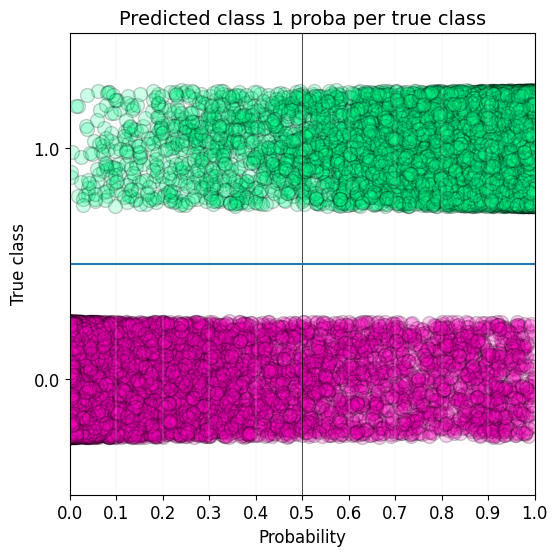

In [27]:
learn.show_probas()

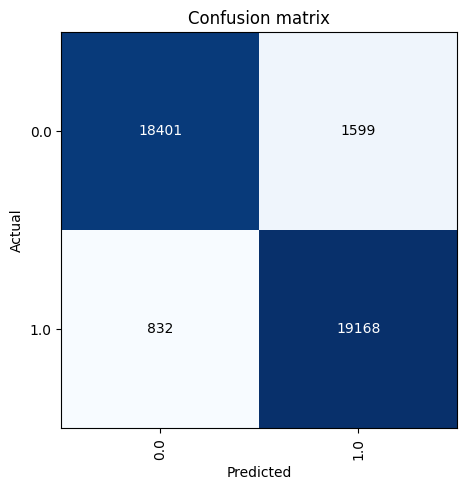

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Inference


#### Extrac the dataset 
Run just for the first time


In [42]:
from glob import glob
pv_farms = glob(f"{data_dir}/s2/germany/*.nc")
te_pv_samples = s2_data(pv_farms[:500])
te_non_pv_samples = s2_data(pv_farms[:500], invert=True)

np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy', te_pv_samples)
np.save(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy', te_non_pv_samples)


#### test predctions

In [59]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_non_pv_samples = np.nan_to_num(te_non_pv_samples, nan=-999999)

te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

te_samples = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])


In [60]:
InceptionTime_model = load_learner(f'{data_dir}/s2/germany/models/temporal_models/Inception_time_temporal_1.pkl', cpu=False)
probas, target, te_pred = InceptionTime_model.get_X_preds(te_samples)
te_pred = np.array(np.argmax(probas, axis=1))

In [61]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.5511462714622486


In [62]:
## Predict just the photovoltaic pixels

probas, target, te_pred = InceptionTime_model.get_X_preds(te_pv_samples)

te_pred = np.array(np.argmax(probas, axis=1))
test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.2195452492094564


#### Inference all dataset

In [52]:
InceptionTime_model = load_learner(f'../models/non_temporal_models/Inception_time_non_temporal_1.pkl', cpu=False)

In [58]:
te_non_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_non_pv_samples.npy')
te_non_pv_samples = np.nan_to_num(te_non_pv_samples, nan=-999999)

te_pv_samples = np.load(f'{data_dir}/s2/germany/extracted_non_temporal/te_pv_samples.npy')
te_pv_samples = np.nan_to_num(te_pv_samples, nan=-999999)

y1 = np.ones(te_pv_samples.shape[0])
y0 = np.zeros(te_non_pv_samples.shape[0])

KeyboardInterrupt: 

In [ ]:
te_data = np.vstack([te_pv_samples, te_non_pv_samples])
y_test = np.hstack([y1, y0])

In [ ]:
test_ds = dls.dataset.add_test(te_data)

In [ ]:
test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)

In [ ]:
te_pred = np.array(np.argmax(test_probas, axis=1))

In [ ]:
test_score = accuracy_score(te_pred, y_test)
print(f'Test Accuracy Score: {test_score}')

In [37]:
## Predict just the photovoltaic pixels
test_ds = dls.dataset.add_test(te_pv_samples)
y1 = np.ones(te_pv_samples.shape[0])

test_dl = valid_dl.new(test_ds)
next(iter(test_dl))
test_probas, *_ = InceptionTime_model.get_preds(dl=test_dl, save_preds=None)

te_pred = np.array(np.argmax(test_probas, axis=1))
test_score = accuracy_score(te_pred, y1)
print(f'Test Accuracy Score: {test_score}')

Test Accuracy Score: 0.35139261744966444
